In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/yahoo-answers-10-categories-for-nlp-csv/version_3.3.0.txt
/kaggle/input/yahoo-answers-10-categories-for-nlp-csv/10_categories_of_yahoo_answers_for_nlp_tasks_csv/readme.txt
/kaggle/input/yahoo-answers-10-categories-for-nlp-csv/10_categories_of_yahoo_answers_for_nlp_tasks_csv/classes.txt
/kaggle/input/yahoo-answers-10-categories-for-nlp-csv/10_categories_of_yahoo_answers_for_nlp_tasks_csv/train.csv
/kaggle/input/yahoo-answers-10-categories-for-nlp-csv/10_categories_of_yahoo_answers_for_nlp_tasks_csv/test.csv
/kaggle/input/glove-twitter/glove.twitter.27B.200d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.25d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.50d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.100d.txt


In [2]:
import tensorflow as tf

import tensorflow.keras.layers as layer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

2024-07-17 07:32:27.555412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 07:32:27.555570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 07:32:27.703992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load data

In [3]:
dftrain = pd.read_csv('/kaggle/input/yahoo-answers-10-categories-for-nlp-csv/10_categories_of_yahoo_answers_for_nlp_tasks_csv/train.csv')
dftest = pd.read_csv('/kaggle/input/yahoo-answers-10-categories-for-nlp-csv/10_categories_of_yahoo_answers_for_nlp_tasks_csv/test.csv')

In [4]:
#Deleting NaN Rows
dftrain=dftrain.dropna()
dftest=dftest.dropna()

In [5]:
len(dftrain)

753637

In [6]:
# Taking only a small peice of the dataset to avoid long training time
test = dftest.iloc[:100000,:]
val = dftrain.iloc[:50000,:]
train = dftrain.iloc[:100000,:]

# Splitting data to train and validation sets manually, only including neccessary columns
X_train = train['best_answer'].values
y_train = train['class_index'].values

X_val = val['best_answer'].values
y_val = val['class_index'].values

X_test = test['best_answer'].values
y_test = test['class_index'].values

In [7]:
len(X_train), len(X_val), len(X_test)

(100000, 50000, 32265)

In [8]:
X_train[0]

'Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \\nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.'

# Process the y labels

In [9]:
labels = np.arange(10)
labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
y_train, y_test, y_val, y_train.shape, y_test.shape, y_val.shape

(array([ 5,  6,  3, ...,  4, 10,  4]),
 array([9, 2, 2, ..., 9, 8, 5]),
 array([5, 6, 3, ..., 5, 7, 7]),
 (100000,),
 (32265,),
 (50000,))

In [11]:
# Encoding Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
num_classes=10 # 1 = Society & Culture 2 = Science & Mathematics 3 = Health 4 = Education & Reference 5 = Computers & Internet 6 = Sports 7 = Business & Finance 8 = Entertainment & Music 9 = Family & Relationships 10 = Politics & Government

y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_val_le = le.transform(y_val)

In [12]:
y_train_le.shape, y_train_le

((100000,), array([4, 5, 2, ..., 3, 9, 3]))

# Tokenizing

https://www.kaggle.com/code/lorresprz/covid19-tweet-analysis-rnn-lstm-others#General-model-with-pretrained-GloVe-Embedding

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [15]:
#This returns a dictionary
word_index = tokenizer.word_index
vocab_size = len(word_index)+1
len(word_index.items())

157040

In [16]:
list(word_index.items())[100:110]

[('into', 101),
 ('well', 102),
 ('had', 103),
 ('many', 104),
 ('its', 105),
 ('take', 106),
 ('even', 107),
 ('help', 108),
 ('much', 109),
 ('question', 110)]

In [17]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [18]:
#find max sequence length
#maxlen = 0
#for i in range(len(X_train_seq)):
#    if len(X_train_seq[i]) > maxlen:
#        maxlen = len(X_train_seq[i])

#maxlen

In [19]:
#this automatically pad the list using the max length found in the list
X_train_pad = pad_sequences(X_train_seq, padding='post')
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen =X_train_pad.shape[1] )
X_val_pad = pad_sequences(X_val_seq, padding='post',maxlen =X_train_pad.shape[1])

In [20]:
X_train_pad.shape, X_test_pad.shape, X_val_pad.shape

((100000, 836), (32265, 836), (50000, 836))

# Glove embedding

In [21]:
glove_file = '/kaggle/input/glove-twitter/glove.twitter.27B.50d.txt'

In [22]:
#Checking the number of word vectors
embeddings_index = {}

f = open(glove_file)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 1193514 word vectors.


In [23]:
list(embeddings_index.items())[3:5]

[('rt',
  array([ 0.68243  ,  0.73589  ,  0.017529 , -0.13763  ,  0.36029  ,
          0.51704  ,  0.1954   ,  0.75219  ,  0.43029  ,  1.0728   ,
          0.05725  ,  0.60043  , -2.4946   ,  0.032148 , -0.44991  ,
          0.0097306, -0.013653 , -0.51001  ,  0.25079  , -0.34493  ,
          0.33606  , -0.0096185, -0.51301  ,  0.1276   ,  0.85964  ,
         -0.78568  , -0.1914   , -0.0033234,  0.89442  ,  0.39503  ,
         -0.95075  ,  0.93803  , -0.31701  ,  0.56457  ,  1.0153   ,
          0.86391  , -0.19971  ,  0.47159  , -0.26864  ,  0.12548  ,
         -2.749    , -0.55106  ,  0.040409 ,  0.29164  , -0.28792  ,
         -0.02274  , -0.40295  ,  0.14771  ,  0.080503 , -0.68115  ],
        dtype=float32)),
 (',',
  array([ 1.3744e-01, -1.0151e+00, -5.0491e-01,  2.6983e-01, -7.5571e-01,
          1.1014e+00,  7.7018e-02, -1.5144e-01,  6.1658e-02,  4.9442e-01,
          3.9051e-01, -2.7450e-03, -3.3434e+00,  4.7171e-01,  2.3165e-01,
         -3.3471e-01, -6.2522e-02, -2.8092e-01,

In [24]:
embedding_vector = embeddings_index.get('.')
embedding_vector

array([ 0.68661 , -1.0772  ,  0.011114, -0.24075 , -0.3422  ,  0.64456 ,
        0.54957 ,  0.30411 , -0.54682 ,  1.4695  ,  0.43648 , -0.34223 ,
       -2.7189  ,  0.46021 ,  0.016881,  0.13953 ,  0.020913,  0.050963,
       -0.48108 , -1.0764  , -0.16807 , -0.014315, -0.55055 ,  0.67823 ,
        0.24359 , -1.3179  , -0.036348, -0.228   ,  1.0337  , -0.53221 ,
       -0.52934 ,  0.35537 , -0.44911 ,  0.79506 ,  0.56947 ,  0.071642,
       -0.27455 , -0.056911, -0.42961 , -0.64412 , -1.3495  ,  0.23258 ,
        0.25383 , -0.10226 ,  0.65824 ,  0.16015 ,  0.20959 , -0.067516,
       -0.51952 , -0.34922 ], dtype=float32)

In [25]:
embed_dim = 50
embedding_matrix = np.zeros((vocab_size, embed_dim))
print(embedding_matrix.shape)

for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector

(157041, 50)


 # Generic model (no Glove embedding)

In [26]:
def generic_model(model_layer,units, epochs, bs):
    EPOCHS = epochs
    BATCH_SIZE = bs
    embedding_dim = 20

    model= tf.keras.Sequential([
        layer.Embedding(vocab_size, embedding_dim, input_length=X_train_pad.shape[1]),
        model_layer(units,return_sequences = True),
        layer.GlobalMaxPooling1D(),
        layer.Dense(10,activation = 'softmax')
    ])
    
    model.summary()
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

    model.compile(loss=SparseCategoricalCrossentropy(from_logits = False),
              optimizer='adam',metrics=['accuracy'])
            
    history = model.fit(X_train_pad, y_train_le, epochs=EPOCHS, 
                        validation_data = (X_val_pad, y_val_le), batch_size=BATCH_SIZE,
                        callbacks = [callback])
    hist_model = pd.DataFrame(history.history)
    
    #Plot the loss and accuracy curves
    fig, ax = plt.subplots(2,1, figsize = (8,8))
    ax[0].plot(hist_model.loss, c = 'b')
    ax[0].plot(hist_model.val_loss, c = 'r')
    ax[0].set_title('Training and validation losses');
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(hist_model.accuracy, c = 'b')
    ax[1].plot(hist_model.val_accuracy, c = 'r')
    ax[1].set_title('Training and validation accuracies');
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    
    #Prediction
    print('APPLYING THE TRAINED MODEL TO THE TEST SET')
    pred = np.argmax(np.round(model.predict(X_test_pad)),axis = 1)
    loss, acc = model.evaluate(X_test_pad,y_test_le,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
    
                 
    #Confustion matrix
    confm = confusion_matrix(y_test_le, pred)
    cm= pd.DataFrame(confm, index = [i for i in labels],
                    columns = [i for i in labels])

    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.show()
                
    return model, hist_model, loss, acc, cm

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 39ms/step - accuracy: 0.2701 - loss: 2.0651 - val_accuracy: 0.4919 - val_loss: 1.4960
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.5189 - loss: 1.4445 - val_accuracy: 0.6348 - val_loss: 1.1551
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.6297 - loss: 1.1536 - val_accuracy: 0.7077 - val_loss: 0.9504
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.6949 - loss: 0.9675 - val_accuracy: 0.7506 - val_loss: 0.8249
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.7397 - loss: 0.8379 - val_accuracy: 0.7800 - val_loss: 0.7261
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.7762 - loss: 0.7286 - val_accuracy: 0.8156 - val_loss: 0.6186
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.8004 - loss: 0.6563 - val_accuracy: 0.8304 - val_loss: 0.5642
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.8220 -

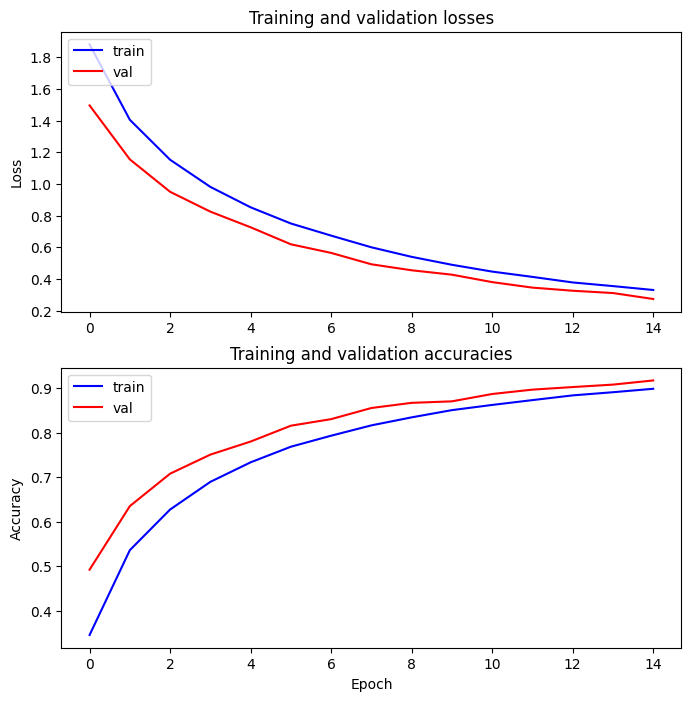

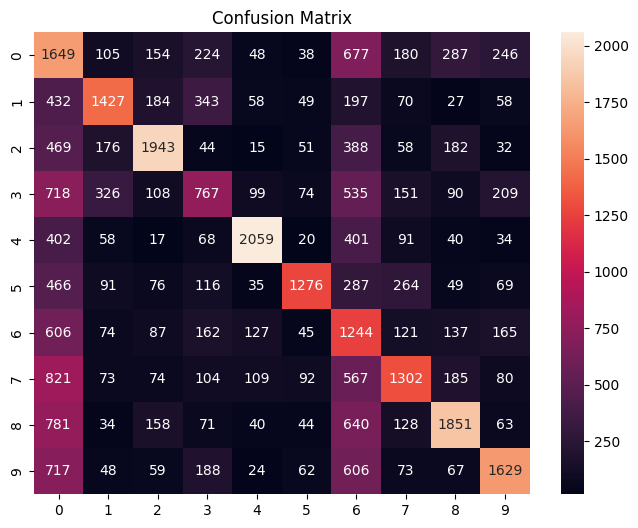

In [27]:
model_LSTM = generic_model(layer.LSTM, 24, 15, 64)

# Generic model with Glove embedding

In [28]:
#Define the embedding layer for the neural network
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          embed_dim,
                                          weights=[embedding_matrix],
                                          input_length=X_train_pad.shape[1],
                                          trainable=False)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
def generic_model_pretrained_embedding(model_layer, units, epochs, bs, bidir=False):
#This function allows for a Bidirectional wrapper if the parameter bidir = True
    EPOCHS = epochs
    BATCH_SIZE = bs
    
    sequence_input = layer.Input(shape=(X_train_pad.shape[1],),)
    embedding_sequences = embedding_layer(sequence_input)
    x = layer.SpatialDropout1D(0.2)(embedding_sequences)
    x = layer.Conv1D(32, 5, activation='relu')(x)
    if bidir:
        x = layer.Bidirectional(model_layer(units, return_sequences = True))(x)
    else:
        x = model_layer(units, return_sequences = True)(x)
    x = layer.GlobalMaxPooling1D()(x)
    outputs = layer.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(sequence_input, outputs)
    model.summary()

    model.compile(loss=SparseCategoricalCrossentropy(from_logits = False),
              optimizer='adam',metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
    history = model.fit(X_train_pad, y_train_le, epochs=EPOCHS, 
                        validation_data = (X_val_pad, y_val_le), batch_size=BATCH_SIZE,
                       callbacks = [callback])
    hist_model = pd.DataFrame(history.history)
    
    
    #Plot the loss and accuracy curves
    fig, ax = plt.subplots(2,1, figsize = (8,8))
    ax[0].plot(hist_model.loss, c = 'b')
    ax[0].plot(hist_model.val_loss, c = 'r')
    ax[0].set_title('Training and validation losses');
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(hist_model.accuracy, c = 'b')
    ax[1].plot(hist_model.val_accuracy, c = 'r')
    ax[1].set_title('Training and validation accuracies');
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    
    #Prediction
    print('APPLYING THE TRAINED MODEL TO THE TEST SET')
    pred = np.argmax(np.round(model.predict(X_test_pad)),axis = 1)
    loss, acc = model.evaluate(X_test_pad,y_test_le,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
    
                 
    #Confustion matrix
    confm = confusion_matrix(y_test_le, pred)
    cm= pd.DataFrame(confm, index = [i for i in labels],
                    columns = [i for i in labels])

    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.show()
                
    return model, hist_model, loss, acc, cm

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 836)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 836, 50)        │     7,852,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 836, 50)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 832, 32)        │         8,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 832, 24)        │         5,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 24)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,865,804 (30.01 MB)

 Trainable params: 13,754 (53.73 KB)

 Non-trainable params: 7,852,050 (29.95 MB)

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 38ms/step - accuracy: 0.3506 - loss: 1.8620 - val_accuracy: 0.5145 - val_loss: 1.4417
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 38ms/step - accuracy: 0.4895 - loss: 1.5080 - val_accuracy: 0.5346 - val_loss: 1.3785
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.5054 - loss: 1.4557 - val_accuracy: 0.5443 - val_loss: 1.3525
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.5188 - loss: 1.4226 - val_accuracy: 0.5514 - val_loss: 1.3332
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.5239 - loss: 1.4050 - val_accuracy: 0.5548 - val_loss: 1.3172
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.5274 - loss: 1.3886 - val_accuracy: 0.5611 - val_loss: 1.2997
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.5301 - loss: 1.3833 - val_accuracy: 0.5629 - val_loss: 1.2972
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.5349 -

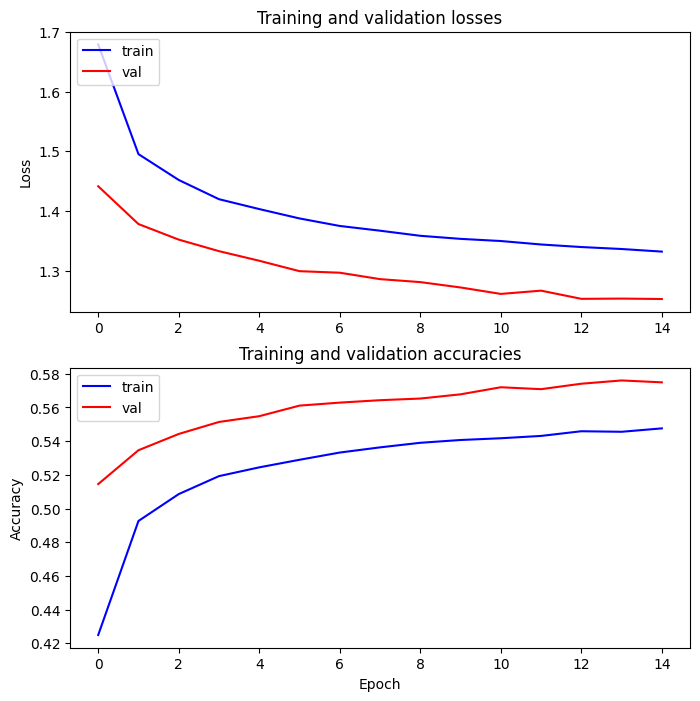

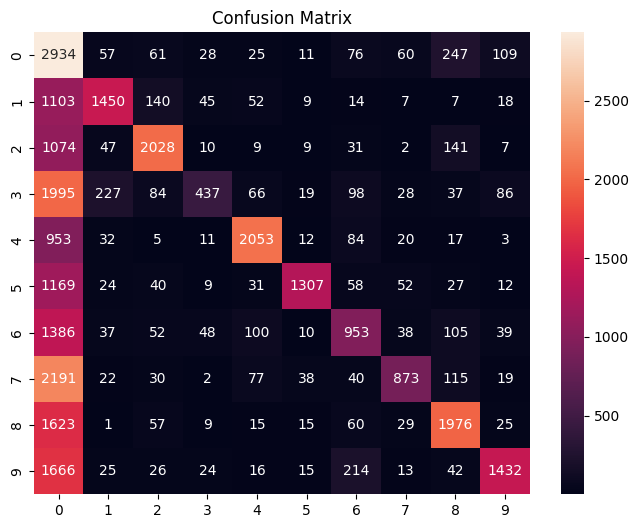

In [30]:
model_LSTM_G = generic_model_pretrained_embedding(layer.LSTM, 24, 15, 64)